# Logistic Regression untuk memprediksi Absen Pekerja

***Membuat modul OOP (Untuk mempersingkat kode) untuk preprocessing dan prediksi berdasarkan model yang dibuat pada tahap pembuatan model***

Pada Kode ini, kita akan memprediksi apakah seorang pekerja akan absen atau tidak berdasarkan parameter2
yang digunakan :

('Date', 'Transportation Expense', 'Distance to Work', 'Age','Daily Work Load Average', 'Body Mass Index', 'Education', 'Children', 'Pets', 'Absenteeism Time in Hours', 'Type of Reasons')

Jika nilai prediksi bernilai 1, maka pekerja tersebut kemungkinan akan melakukan excessive absenteism, 
Jika nilai prediksi bernilai 0, maka pekerja tersebut kemungkinan akan sangat jarang untuk Absen kerja.

In [14]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


class CustomScaler(BaseEstimator,TransformerMixin): 
    
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = StandardScaler(copy,with_mean,with_std)
        self.columns = columns
        self.mean_ = None
        self.var_ = None

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.array(np.mean(X[self.columns]))
        self.var_ = np.array(np.var(X[self.columns]))
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.loc[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]



class absenteeism_model():
      
        def __init__(self, model_file, scaler_file):
            # read the 'model' and 'scaler' files which were saved
            with open('model','rb') as model_file, open('scaler', 'rb') as scaler_file:
                self.reg = pickle.load(model_file)
                self.scaler = pickle.load(scaler_file)
                self.data = None
        
        # take a data file (*.csv) and preprocess it in the same way as in the lectures
        def load_and_clean_data(self, data_file):
            
            # import the data
            df = pd.read_csv(data_file,delimiter=',')
            # store the data in a new variable for later use
            self.df_with_predictions = df.copy()
            # drop the 'ID' column
            df = df.drop(['ID'], axis = 1)
            # to preserve the code we've created in the previous section, we will add a column with 'NaN' strings
            df['Absenteeism Time in Hours'] = 'NaN'

            # create a separate dataframe, containing dummy values for ALL avaiable reasons
            reason_columns = pd.get_dummies(df['Reason for Absence'], drop_first = True)
            
            # split reason_columns into 4 types
            reason_type_1 = reason_columns.loc[:,1:14].max(axis=1)
            reason_type_2 = reason_columns.loc[:,15:17].max(axis=1)
            reason_type_3 = reason_columns.loc[:,18:21].max(axis=1)
            reason_type_4 = reason_columns.loc[:,22:].max(axis=1)
            
            # to avoid multicollinearity, drop the 'Reason for Absence' column from df
            df = df.drop(['Reason for Absence'], axis = 1)
            
            # concatenate df and the 4 types of reason for absence
            df = pd.concat([df, reason_type_1, reason_type_2, reason_type_3, reason_type_4], axis = 1)
            
            # assign names to the 4 reason type columns
            # note: there is a more universal version of this code, however the following will best suit our current purposes             
            column_names = ['Date', 'Transportation Expense', 'Distance to Work', 'Age',
                           'Daily Work Load Average', 'Body Mass Index', 'Education', 'Children',
                           'Pets', 'Absenteeism Time in Hours', 'Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']
            df.columns = column_names

            # re-order the columns in df
            column_names_reordered = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Date', 'Transportation Expense', 
                                      'Distance to Work', 'Age', 'Daily Work Load Average', 'Body Mass Index', 'Education', 
                                      'Children', 'Pets', 'Absenteeism Time in Hours']
            df = df[column_names_reordered]
      
            # convert the 'Date' column into datetime
            df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

            # create a list with month values retrieved from the 'Date' column
            list_months = []
            for i in range(df.shape[0]):
                list_months.append(df['Date'][i].month)

            # insert the values in a new column in df, called 'Month Value'
            df['Month Value'] = list_months

            # create a new feature called 'Day of the Week'
            df['Day of the Week'] = df['Date'].apply(lambda x: x.weekday())


            # drop the 'Date' column from df
            df = df.drop(['Date'], axis = 1)

            # re-order the columns in df
            column_names_upd = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Month Value', 'Day of the Week',
                                'Transportation Expense', 'Distance to Work', 'Age',
                                'Daily Work Load Average', 'Body Mass Index', 'Education', 'Children',
                                'Pets', 'Absenteeism Time in Hours']
            df = df[column_names_upd]


            # map 'Education' variables; the result is a dummy
            df['Education'] = df['Education'].map({1:0, 2:1, 3:1, 4:1})

            # replace the NaN values
            df = df.fillna(value=0)

            # drop the original absenteeism time
            df = df.drop(['Absenteeism Time in Hours'],axis=1)
            
            # drop the variables we decide we don't need
            df = df.drop(['Day of the Week','Daily Work Load Average','Distance to Work'],axis=1)
            
            # we have included this line of code if you want to call the 'preprocessed data'
            self.preprocessed_data = df.copy()
            
            # we need this line so we can use it in the next functions
            self.data = self.scaler.transform(df)
    
        # a function which outputs the probability of a data point to be 1
        def predicted_probability(self):
            if (self.data is not None):  
                pred = self.reg.predict_proba(self.data)[:,1]
                return pred
        
        # a function which outputs 0 or 1 based on our model
        def predicted_output_category(self):
            if (self.data is not None):
                pred_outputs = self.reg.predict(self.data)
                return pred_outputs
        
        # predict the outputs and the probabilities and 
        # add columns with these values at the end of the new data
        def predicted_outputs(self):
            if (self.data is not None):
                self.preprocessed_data['Probability'] = self.reg.predict_proba(self.data)[:,1]
                self.preprocessed_data ['Prediction'] = self.reg.predict(self.data)
                return self.preprocessed_data

In [27]:
topredict = pd.read_csv('Absenteeism_new_data.csv')

In [31]:
topredict.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       40 non-null     int64  
 1   Reason for Absence       40 non-null     int64  
 2   Date                     40 non-null     object 
 3   Transportation Expense   40 non-null     int64  
 4   Distance to Work         40 non-null     int64  
 5   Age                      40 non-null     int64  
 6   Daily Work Load Average  40 non-null     float64
 7   Body Mass Index          40 non-null     int64  
 8   Education                40 non-null     int64  
 9   Children                 40 non-null     int64  
 10  Pets                     40 non-null     int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 3.6+ KB


***Ada 40 pekerja yang akan diprediksi, apakah akan sering melakukan absen atau tidak
Nilai Absenteiism adalah 1 atau 0, dimana 0 berarti akan sangat jarang absen, 
sedangkan 1 berarti akan sangat sering absen***

In [15]:
model = absenteeism_model('model','scaler')

In [16]:
model.load_and_clean_data(topredict)

In [82]:
model.predicted_outputs().head(5)

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Transportation Expense,Age,Body Mass Index,Education,Children,Pets,Probability,Prediction
0,0,0.0,0,1,6,179,30,19,1,0,0,0.127203,0
1,1,0.0,0,0,6,361,28,27,0,1,4,0.864029,1
2,0,0.0,0,1,6,155,34,25,0,2,0,0.265096,0
3,0,0.0,0,1,6,179,40,22,1,2,0,0.202894,0
4,1,0.0,0,0,6,155,34,25,0,2,0,0.719413,1


In [18]:
AbsentPrediction = model.predicted_outputs()

In [56]:
AbsentDF = pd.DataFrame({'ID Pekerja : ':AbsentPrediction.index
                        , 'Kemungkinan Absen Berlebih': AbsentPrediction['Prediction']})

In [57]:
AbsentDF.head(5)

,ID Pekerja :,Kemungkinan Absen Berlebih
0,0,0
1,1,1
2,2,0
3,3,0
4,4,1


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

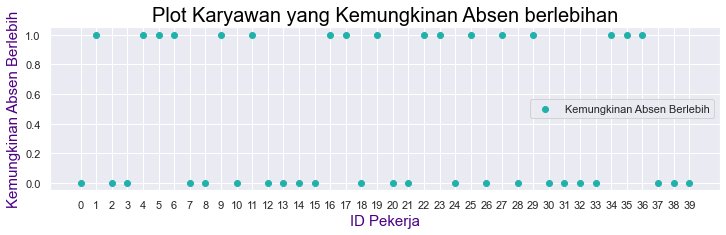

In [81]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(3)
plt.scatter(AbsentPrediction.index, AbsentPrediction['Prediction'], 
            c='lightseagreen',label='Kemungkinan Absen Berlebih')
plt.xlabel('ID Pekerja',c='indigo',size=15)
plt.ylabel('Kemungkinan Absen Berlebih',c='indigo',size=15)
plt.xticks(AbsentPrediction.index)
plt.title('Plot Karyawan yang Kemungkinan Absen berlebihan', c='black',size=20)
plt.legend()


<AxesSubplot:xlabel='Prediction', ylabel='Count'>

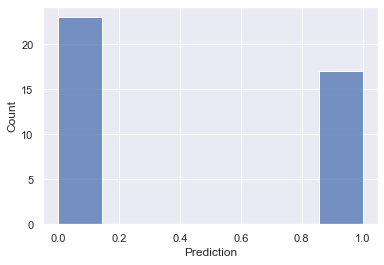

In [53]:
sns.histplot(AbsentPrediction['Prediction'])

In [46]:
AbsentPrediction['Prediction'].describe()

count    40.000000
mean      0.425000
std       0.500641
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Prediction, dtype: float64

In [55]:
unique, counts = np.unique(AbsentPrediction['Prediction'], return_counts = True)
#countspercent = counts/np.sum(counts)
dict({'Jumlah Pekerja yang tidak akan absen berlebih : ':counts[0],
      'Jumlah Pekerja yan akan absen berlebih : ':counts[1]})

{'Jumlah Pekerja yang tidak akan absen berlebih : ': 23,
 'Jumlah Pekerja yan akan absen berlebih : ': 17}